In [2]:
import os
import numpy as np
from scipy.io import wavfile
import random
from matplotlib import pyplot as plt

In [5]:
fnames = os.listdir('../train')
#print(fnames)
n_classes = 10

speaker_idxs = []
for i in range(4):
    speaker_idxs.append(random.randint(0, (len(fnames) // n_classes)-1))

print(speaker_idxs)
X_train, X_test = [], []
y_train, y_test = [], []
len_files = []
for  it in range(len(fnames)):
    fs, tmp = wavfile.read('../train/'+fnames[it])
    #checking if data length is cohesive
    tmp = tmp / max(abs(tmp))
    if len(tmp) < fs:
        len_to_append = fs - len(tmp)
        to_append = np.zeros(len_to_append)
        tmp = np.append(tmp, to_append)
    else:
        tmp = tmp[:fs]
    
    if it//n_classes in speaker_idxs:
        X_test.append(tmp)
        y_test.append(it % n_classes)
    else:
        X_train.append(tmp)
        y_train.append(it % n_classes)
    
# plt.plot(tmp)
# plt.show()
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

[6, 16, 20, 8]


100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 140.93it/s]


(180, 99, 13)
1287


c:\users\wiktor\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 1287)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 128)               164864    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_74 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_75 (Dense)             (None, 10)                650       
Total params: 190,282
Trainable params: 190,282
Non-trainable params: 0
____________________________________________________

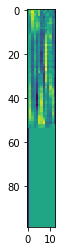

In [143]:
"""MFCC and FNN"""

from python_speech_features import mfcc
from tqdm import tqdm
X_train_mfcc = []
for it in tqdm(range(X_train.shape[0])):
    tmp = X_train[it, :]
    tmp_mfcc = mfcc(tmp).tolist()
    X_train_mfcc.append(tmp_mfcc)
    
X_test_mfcc = []
for it in tqdm(range(X_test.shape[0])):
    tmp = X_test[it, :]
    tmp_mfcc = mfcc(tmp).tolist()
    X_test_mfcc.append(tmp_mfcc)
    
X_train_mfcc = np.array(X_train_mfcc)
X_test_mfcc = np.array(X_test_mfcc)

print(X_train_mfcc.shape)
plt.imshow(X_train_mfcc[100, :, :])

from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import unit_norm
from keras.optimizers import Adam

input_shape = X_train_mfcc.shape[1] * X_train_mfcc.shape[2]
print(input_shape)

X_train_mfcc_flat = np.reshape(X_train_mfcc, (-1, input_shape))
X_test_mfcc_flat = np.reshape(X_test_mfcc, (-1, input_shape))

"""onehoting network outputs"""
from keras.utils import to_categorical
y_train_onehot = to_categorical(y_train, 10)
y_test_onehot = to_categorical(y_test, 10)

model_dense_input = Input(shape=(input_shape,))
model_dense = Dense(units=128, activation='relu', input_dim=input_shape,
             kernel_constraint=unit_norm())(model_dense_input)
model_dense = Dropout(0.5)(model_dense)
model_dense = Dense(units=128, activation='relu')(model_dense)
model_dense = Dense(units=64, activation='relu')(model_dense)
model_dense = Dense(units=10, activation='softmax')(model_dense)
model_dense = Model(inputs=model_dense_input, output=model_dense)

model_dense.summary()

adam = Adam(lr = 0.001)
model_dense.compile(loss='categorical_crossentropy',
             optimizer = adam, metrics=['accuracy'])

model_dense.fit(X_train_mfcc_flat, y_train_onehot, epochs=100, steps_per_epoch=1, 
          validation_data=(X_test_mfcc_flat, y_test_onehot), validation_steps=100)

In [150]:
def predict_mfcc_to_digit(data, fs, model):
    if len(data) < fs:
        len_to_append = fs - len(data)
        to_append = np.zeros(len_to_append)
        data = np.append(data, to_append)
    else:
        data = data[:fs]
        
    data_mfcc = mfcc(data, fs)
    input_shape = data_mfcc.shape[0] * data_mfcc.shape[1]
    data_mfcc = np.reshape(data_mfcc, (1, input_shape))
    
    prediction = model.predict(data_mfcc)
    digit = np.argmax(prediction)
    
    return digit

In [153]:
fs, data = wavfile.read('ex_data.wav')
print(predict_mfcc_to_digit(data, fs, model_dense))

9


In [154]:
model_dense.save('model_mfcc_dense.h5')